In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir
import uproot
import root_pandas
%load_ext jupyternotify

Welcome to JupyROOT 6.27/01


<IPython.core.display.Javascript object>

In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon,ThetaPQ ):## '__init__' is the constructor of the class
        self.virtual_photon = virtual_photon
        Nu = virtual_photon.E()   ##components of a 4-vector TLorentzVector
        Q2 = -virtual_photon.M2() ## magnitud squared of a 4-vector TLorentzVector
        self.proton = ROOT.TLorentzVector()  ## proton is an attribute of the class 'particle' just created.
        self.proton.SetPxPyPzE(0,0,0, 0.938)  ## SetPxPyPzE is just a function of ROOT
        self.W = (virtual_photon + self.proton).M() ##.M() return the magnitud of a TLorentzVector [W2=(p+q)2]
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect())) ## sign returns -1 0 or 1 if the input is negative, zero or positive.
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition, virtual photon
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.LorentzVector = fourvector #hadron four-vector. 4-vector is an input of this class
        self.PhiLab = self.LorentzVector.Phi()
        self.ThetaLab = self.LorentzVector.Theta()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star) # y is rapidity
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan2(self.Pt,self.Pl)
        self.P = np.sqrt(self.LorentzVector.Px()**2+self.LorentzVector.Py()**2+self.LorentzVector.Pz()**2)
      
    def redefine(self, new_virtual_photon):
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = new_virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = new_virtual_photon.Vect().Cross(self.LorentzVector.Vect()).Unit()
        sign  = np.sign(part1.Dot(self.LorentzVector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2)) 
        self.Pt = self.LorentzVector.Vect().Perp(new_virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.LorentzVector.Vect().Dot(new_virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.virtual_photon = new_virtual_photon
        
        return
        
    def print_properties(self):
        print ('Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W)
        print ('zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y)
        print ('pid = ' , self.pid)       
        
    

In [3]:
def getDataframes(filename, Target=1,maxevents=1e9,tree_name='ntuple_data',isMC=False,
                  keepH1FailRecon=False,keepH2FailRecon=False, h2CutsTruth=False,
                 keepEFailRecon=False, makeTriggerTuple=True,includeRunNumber=False):
    dphi = np.array([])  
    include_truth=isMC
    ParticlesFromPrevious = []
    
    try:
        myfile = TFile.Open('%s'%filename,'READ')
        myfile.Print()
    except:
        print("could not open file")
    mytree = myfile.Get(tree_name)
        
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    
    
    ## here we create another dictionary
    
    tupla_trigger = {}
    tupla_secondary = {}
    for tupla in tupla_trigger, tupla_secondary:
        tupla['h_pid'] = []
        tupla['h_xf'] = []
        tupla['h_z']  = []
        tupla['h_cm_pt'] = []
        tupla['h_rap']  = []
        tupla['ycm'] = []
        tupla['Q2'] = []
        tupla['x'] = []
        tupla['nu'] = []
        tupla['W'] = []
        tupla['e_px'] = [] 
        tupla['e_py'] = []
        tupla['e_pz']  = []
        tupla['e_p'] = [] 
        tupla['e_ph'] = []
        tupla['e_th']  = []    
        tupla['SampFracEl25'] = []
        tupla['SampFracEl20'] = []
        tupla['TargTypeSM'] = [] ## RD's vertex cuts
        tupla['TargType'] = []   ## Taisiya's vertex cuts (nominal)
        tupla['h_cm_ph'] = []
        tupla['h_cm_th'] = []
        tupla['TargType'] = []
        tupla['h_p'] = []
        tupla['h_ph'] = []
        tupla['h_th'] = []
        tupla['h_deltaZ'] = []
        tupla['h_Nphe'] = []
        tupla['h_Sector'] = []
        tupla['h_FidCut'] = []
        tupla['h_FidCutPiPlus'] = []
        tupla['h_Chi2CC'] = []
        tupla['h_StatCC'] = []
        tupla['h_T4'] = []
        tupla['evnt'] = []
    
    if include_truth:
        mytree.mc_W = 0.938**2+mytree.mc_Nu*0.938*2-mytree.mc_Q2
        
    
    start = time.time()
    print('About to loop over ', mytree.GetEntries() , ' entries')
    for ievt  in range(mytree.GetEntries()):
        
        #print('evnt: ',ievt, 'len ParticlesFromPrevious ', (len(ParticlesFromPrevious)))
        
        #for kkk  in range (len(ParticlesFromPrevious)):
        #    print('evnt',ievt, 'ParticlesFromPrevious, pid:', ParticlesFromPrevious[kkk].pid, 'zh: ', 
                   #ParticlesFromPrevious[kkk].Zh, 'W: ',ParticlesFromPrevious[kkk].W )
        #if len(mytree.FidCheckCut) != len(mytree.Sector):
        #    print('This shouldn\'t ever happen: len(mytree.FidCheckCut) != len(mytree.Sector). Skipping event')
        #    continue
            
        mytree.GetEntry(ievt)   
        if (mytree.W<2.05 or mytree.Q2<1.0) and not keepEFailRecon : continue
            
        if keepEFailRecon and (mytree.mc_Q2<1.0 and mytree.Q2<1.0 or \
                               mytree.W<2.05 and .9383**2+2*.9383*mytree.mc_Nu-mytree.mc_Q2<2.05 or\
                               mytree.mc_Nu>4.2):
            continue
        #if mytree.Q2<1 :
        #    print(mytree.Q2, mytree.mc_Q2)
        
        # by default we apply the loose vertex cuts (Hayk's) The other cases remains as variables
        if ievt>maxevents: break        
        if(mytree.TargTypeHH==1) :
            TargType=1
        elif(mytree.TargTypeHH==2):
            TargType=2
        else:
            TargType=0
        #print (TargType,  ' ' , Target)
        if not(isMC) and (TargType!=Target): continue ## 'Target' is a argument of this function
                
        #print('PASO all cuts')
        W = mytree.W
        Nu = mytree.Nu
        #get electron momentum:
        Pe = np.sqrt(mytree.Pex*mytree.Pex + mytree.Pey*mytree.Pey+ mytree.Pez*mytree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(mytree.Pex, mytree.Pey, mytree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        virtual_photon_unitvector = virtual_photon.Vect().Unit()
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        
        
        if include_truth:
            Nu_truth = mytree.mc_Nu
            Pe_truth = np.sqrt(mytree.mc_Pex*mytree.mc_Pex + mytree.mc_Pey*mytree.mc_Pey+ mytree.mc_Pez*mytree.mc_Pez)
            scattered_e_truth = ROOT.TLorentzVector()
            scattered_e_truth.SetPxPyPzE(mytree.mc_Pex, mytree.mc_Pey, mytree.mc_Pez, Pe_truth)
            virtual_photon_truth  = incoming_e - scattered_e_truth 
            virtual_photon_unitvector_truth = virtual_photon_truth.Vect().Unit()
        run=0
        if not isMC:
            if includeRunNumber:
                run = mytree.run
            else : run = -1
        ## for each event the particles are saved in the 'particles' list.        
        particles = []  ## this is how you define a list in python, this is created for each event
        #print (' Entering main loop over particles')
        for i in range(len(mytree.pid)):
            #print(mytree.pid[i])
            ## when the condition is true the 'continue' statement
            ## takes me to the next iteration of the loop
            
            if not keepH1FailRecon:
            
                if (abs(mytree.pid[i]) !=211 and mytree.pid[i]!=2212): continue 

                ## aplying the rest of cuts:
                if ( mytree.P[i]<0.2 or mytree.ThetaLab[i]<10 or mytree.ThetaLab[i]>120 ):    continue
                if ( mytree.pid[i]!=211) : continue #only leading pi+ in this analysis
                if ( mytree.pid[i]==211  and mytree.P[i]>=3.0 and 
                    (mytree.Nphe[i]<10 or mytree.Chi2CC[i]>0.0872 
                     or mytree.StatCC[i]<=0 or mytree.NRowsCC[i]==0) ):    continue     
            else:
                if mytree.mc_pid[i] !=211 and mytree.pid[i] !=211: continue 

            #print(mytree.pid[i])
            i_lv = ROOT.TLorentzVector()    ## 4-vector of the hadron
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu) 
            ## this is the 4-vector of the hadron
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i] ) 
            
            if include_truth:
                i_lv_truth = ROOT.TLorentzVector()    ## 4-vector of the hadron
                i_lv_truth.SetPxPyPzE(mytree.mc_Px[i],mytree.mc_Py[i],mytree.mc_Pz[i],mytree.mc_Zh[i]*Nu_truth) ## this is the 4-vector of the hadron
                i_part_truth = particle(mytree.mc_pid[i], i_lv_truth, virtual_photon_truth, mytree.mc_ThetaPQ[i] ) ## particle is the class defined previously
             
            
            
            ## particle is the class defined previously
            ## in this 'particles' list there are NO cuts applied (except the pid and obvious ones)
            particles.append(i_part)   ## save that particle in the 'particles' list
            X = (virtual_photon + proton -  i_part.LorentzVector) #unobserved hadronic system
            #print('event:',ievt,'particle i:', i,' with PID:',  i_part.pid, 'and Zh:',
            #       i_part.Zh, ', W: ',i_part.W)
            e_p = np.sqrt(mytree.Pex**2+mytree.Pey**2+mytree.Pez**2)
            e_ph = np.arctan2(mytree.Pey,mytree.Pex)
            e_th = np.arctan2(np.sqrt(mytree.Pex**2+mytree.Pey**2),mytree.Pez)
            if i_part.Zh > 0.5 and i_part.pid ==211: #only save triggers and do correlations if they have z>0.5
            #if i_part.Pt>1.0: #only save triggers if pT>1.0 
            ## HERE WE SAVE THE VARIABLES FOR THE TRIGGER PARTICLE (THE ONE WITH Zh>0.5)
               
                tupla_trigger['h_pid'].append(i_part.pid)
                
                tupla_trigger['h_xf'].append(i_part.Xf)
                tupla_trigger['h_z'].append(i_part.Zh)
                tupla_trigger['h_cm_pt'].append(i_part.Pt)
                tupla_trigger['h_rap'].append(i_part.y_star)
                tupla_trigger['ycm'].append(i_part.ycm)
                tupla_trigger['h_cm_ph'].append(i_part.PhiPQ)
                tupla_trigger['h_cm_th'].append(i_part.ThetaPQ)
                tupla_trigger['Q2'].append(mytree.Q2)
                tupla_trigger['x'].append(mytree.Xb)
                tupla_trigger['nu'].append(mytree.Nu)
                tupla_trigger['W'].append(mytree.W)
                tupla_trigger['e_px'].append(mytree.Pex)
                tupla_trigger['e_py'].append(mytree.Pey)
                tupla_trigger['e_pz'].append(mytree.Pez)
                tupla_trigger['e_p'].append(e_p)
                tupla_trigger['e_ph'].append(e_ph)
                tupla_trigger['e_th'].append(e_th)
                tupla_trigger['h_T4'].append(mytree.T4[i])
                tupla_trigger['SampFracEl25'].append(mytree.SampFractionEl25)
                tupla_trigger['SampFracEl20'].append(mytree.SampFractionEl20)
                tupla_trigger['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                tupla_trigger['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                tupla_trigger['h_p'].append(mytree.P[i])
                tupla_trigger['h_ph'].append(mytree.PhiLab[i])
                tupla_trigger['h_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #print 'mytree.Pt[i] ' , mytree.Pt[i], ' check: ' ,i_part.Vector.Perp(virtual_photon_unitvector)

                #print('Testing theta PQ', mytree.ThetaPQ[i],  ' '  , 180.0*i_part.ThetaPQ/np.pi)
                #print('Testing phi PQ', mytree.PhiPQ[i],  ' '  , 180.0*i_part.PhiPQ/np.pi),Nphe,deltaZ
                tupla_trigger['h_deltaZ'].append(mytree.deltaZ[i])
                tupla_trigger['h_Nphe'].append(mytree.Nphe[i])
                tupla_trigger['h_Sector'].append(mytree.Sector[i])
                tupla_trigger['h_FidCut'].append(mytree.FidCheckCut[i])
                tupla_trigger['h_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[i])
                tupla_trigger['h_Chi2CC'].append(mytree.Chi2CC[i])
                tupla_trigger['h_StatCC'].append(mytree.StatCC[i])
                tupla_trigger['evnt'].append(mytree.evnt)
                
            for j in range(len(mytree.pid)): 
                pass_recon=True
                if mytree.pid[j]!=2212: pass_recon=False
                #print('evnt', ievt,' j:', j, ' , lenpid:',len(mytree.pid) )
                ## aplying the rest of cuts:
                if ( mytree.P[j]<0.35 or mytree.ThetaLab[j]<10 or mytree.ThetaLab[j]>120 or mytree.pid[j] != 2212 or mytree.P[j]>3.0):    pass_recon=False
                if not pass_recon:
                   continue
                
                j_lv = ROOT.TLorentzVector()    
                j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)
                j_part = particle(mytree.pid[j], j_lv, virtual_photon, mytree.ThetaPQ[j] )
                ## particle is the defined class
                
                
                tupla_secondary['h_z'].append(j_part.Zh)
                tupla_secondary['h_cm_pt'].append(j_part.Pt)
                tupla_secondary['h_xf'].append(j_part.Xf)
                tupla_secondary['h_rap'].append(j_part.y_star)
                tupla_secondary['h_pid'].append(j_part.pid)
                tupla_secondary['h_cm_ph'].append(j_part.PhiPQ)
                tupla_secondary['h_cm_th'].append(j_part.ThetaPQ)
                tupla_secondary['Q2'].append(mytree.Q2)
                tupla_secondary['x'].append(mytree.Xb)
                tupla_secondary['nu'].append(mytree.Nu)
                tupla_secondary['W'].append(mytree.W)
                tupla_secondary['SampFracEl25'].append(mytree.SampFractionEl25)
                tupla_secondary['SampFracEl20'].append(mytree.SampFractionEl20)
                tupla_secondary['TargTypeSM'].append(mytree.TargTypeSM)  ## RD's vertex cuts
                tupla_secondary['TargType'].append(mytree.TargType)    ## Taisiya's vertex cuts (nominal)
                tupla_secondary['h_ph'].append(mytree.PhiLab[j])
                tupla_secondary['h_th'].append(mytree.ThetaLab[j])
                tupla_secondary['h_p'].append(mytree.P[j])
                tupla_secondary['h_deltaZ'].append(mytree.deltaZ[j])
                tupla_secondary['ycm'].append(i_part.ycm)

                tupla_secondary['h_Nphe'].append(mytree.Nphe[j])
                tupla_secondary['h_Sector'].append(mytree.Sector[j])
                tupla_secondary['h_FidCut'].append(mytree.FidCheckCut[j]) 
                tupla_secondary['h_FidCutPiPlus'].append(mytree.FidCheckCutPiPlus[j])                    
                tupla_secondary['h_Chi2CC'].append(mytree.Chi2CC[j])
                tupla_secondary['h_StatCC'].append(mytree.StatCC[j])
                tupla_secondary['h_T4'].append(mytree.T4[j])
                tupla_secondary['evnt'].append(mytree.evnt)
                
                tupla_secondary['e_px'].append(mytree.Pex)
                tupla_secondary['e_py'].append(mytree.Pey)
                tupla_secondary['e_pz'].append(mytree.Pez)
                tupla_secondary['e_p'].append(e_p)
                tupla_secondary['e_ph'].append(e_ph)
                tupla_secondary['e_th'].append(e_th)
                
    print("secondary")                
    for f in tupla_secondary:
        print(f, len(tupla_secondary[f]))
    print("trigger")                
    for f in tupla_trigger:
        print(f, len(tupla_trigger[f]))     
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    ##printing the 3 tuples to the output file
    df_trigger = pd.DataFrame(tupla_trigger)
    df_secondary= pd.DataFrame(tupla_secondary)
    #print ('Number of triggers with z>0.5,  ', df.query('h1_z>0.5').shape[0])
    #print ('Number of pairs with z>0.5, '    , df_trigger.query('h1_z>0.5').shape[0]) 
    myfile.Close()
    return df_trigger, df_trigger
        

In [4]:
## here we defined some dictionaries ({})
df = {}

# Data files

In [5]:
%%notify
%time


df['C_secondary'], df['C_trigger'] = [None,None]
df['D_C_secondary'], df['D_C_trigger'] = [None,None]
#path = '/home/sebouh/di-hadron/data/P27/ca/'
path = '/home/sebouh/di-hadron/low_energy_protons/'
#path='/home/seba/'
tar='C'
import glob
Files = glob.glob(path+f"{tar}*.root") 
count=0
for name in Files:
    filename = name
    print ('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue 
    trigger, secondary = getDataframes(filename,Target=2, maxevents=10000) ## getDataframes is a function just created
    df[tar+"_secondary"] = pd.concat([ df[tar+"_secondary"], secondary])
    df[tar+"_trigger"] = pd.concat([ df[tar+"_trigger"], trigger])
    trigger, secondary =  getDataframes(filename,Target=1,maxevents=10000) ## getDataframes is a function just created
    df["D_"+tar+"_secondary"] = pd.concat([ df["D_"+tar+"_secondary"], secondary])
    df["D_"+tar+"_trigger"] = pd.concat([ df["D_"+tar+"_trigger"], trigger])
    


CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.06 µs
done with:  0  files
/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root  has  29006299  entries
About to loop over  29006299  entries
secondary
h_pid 255
h_xf 255
h_z 255
h_cm_pt 255
h_rap 255
ycm 255
Q2 255
x 255
nu 255
W 255
e_px 255
e_py 255
e_pz 255
e_p 255
e_ph 255
e_th 255
SampFracEl25 255
SampFracEl20 255
TargTypeSM 255
TargType 255
h_cm_ph 255
h_cm_th 255
h_p 255
h_ph 255
h_th 255
h_deltaZ 255
h_Nphe 255
h_Sector 255
h_FidCut 255
h_FidCutPiPlus 255
h_Chi2CC 255
h_StatCC 255
h_T4 255
evnt 255
trigger
h_pid 70
h_xf 70
h_z 70
h_cm_pt 70
h_rap 70
ycm 70
Q2 70
x 70
nu 70
W 70
e_px 70
e_py 70
e_pz 70
e_p 70
e_ph 70
e_th 70
SampFracEl25 70
SampFracEl20 70
TargTypeSM 70
TargType 70
h_cm_ph 70
h_cm_th 70
h_p 70
h_ph 70
h_th 70
h_deltaZ 70
h_Nphe 70
h_Sector 70
h_FidCut 70
h_FidCutPiPlus 70
h_Chi2CC 70
h_StatCC 70
h_T4 70
evnt 70
Processed in 0.46916699409484863 seconds
/home/sebouh/di-hadron/low_energy_protons/C_dat

<IPython.core.display.Javascript object>

TFile: name=/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/low_energy_protons/C_data_hadd.root, title=, option=READ


In [ ]:
#create a mixed tuple



In [30]:

import pickle
with open(f"data_pion_proton_pairs_{tar}.pkl", "wb") as f:
    pickle.dump({a:df[a] for a in f"{tar} D_{tar} {tar}_trigger D_{tar}_trigger {tar}_mix D_{tar}_mix".split()}, f, pickle.HIGHEST_PROTOCOL)
print('end')

end


In [31]:
#path = '/home/sebouh/di-hadron/data/P27/fe/'
path = '/home/sebouh/di-hadron/low_energy_protons/'
#path='/home/seba/'
tar='Fe'
import glob
Files = glob.glob(path+f"{tar}*.root") 
count=0
for name in Files:
    filename = name
    print ('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue 
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2) ## getDataframes is a function just created
    df[tar] = pd.concat([ df[tar], pairs])
    df['%s_mix'%tar] = pd.concat([ df['%s_mix'%tar], pairs_mix])
    df['%s_trigger'%tar] = pd.concat([ df['%s_trigger'%tar], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1) ## getDataframes is a function just created
    df['D_%s'%tar] = pd.concat([ df['D_%s'%tar], pairs])
    df['D_%s_mix'%tar] = pd.concat([ df['D_%s_mix'%tar], pairs_mix])
    df['D_%s_trigger'%tar] = pd.concat([ df['D_%s_trigger'%tar], trigger])
tar = "Fe"
import pickle
with open(f"data_pion_proton_pairs_{tar}.pkl", "wb") as f:
    pickle.dump({a:df[a] for a in f"{tar} D_{tar} {tar}_trigger D_{tar}_trigger {tar}_mix D_{tar}_mix".split()}, f, pickle.HIGHEST_PROTOCOL)
print('end')

print('end')

done with:  0  files
/home/sebouh/di-hadron/low_energy_protons/Fe_data_hadd.root  has  46201904  entries
About to loop over  46201904  entries


/tmp/ipykernel_1781987/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 1539.5320014953613 seconds
Number of triggers with z>0.5,   70123
Number of pairs with z>0.5,  263034
/home/sebouh/di-hadron/low_energy_protons/Fe_data_hadd.root  has  46201904  entries
About to loop over  46201904  entries


/tmp/ipykernel_1781987/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 1601.391226530075 seconds
Number of triggers with z>0.5,   57538
Number of pairs with z>0.5,  469645
end
end
TFile: name=/home/sebouh/di-hadron/low_energy_protons/Fe_data_hadd.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/low_energy_protons/Fe_data_hadd.root, title=, option=READ


In [32]:
#path = '/home/sebouh/di-hadron/data/P27/pb/'
path = '/home/sebouh/di-hadron/low_energy_protons/'
#path='/home/seba/'
tar='Pb'
import glob
Files = glob.glob(path+f"{tar}*.root") 
count=0
for name in Files:
    filename = name
    print ('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue 
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2) ## getDataframes is a function just created
    df[tar] = pd.concat([ df[tar], pairs])
    df['%s_mix'%tar] = pd.concat([ df['%s_mix'%tar], pairs_mix])
    df['%s_trigger'%tar] = pd.concat([ df['%s_trigger'%tar], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1) ## getDataframes is a function just created
    df['D_%s'%tar] = pd.concat([ df['D_%s'%tar], pairs])
    df['D_%s_mix'%tar] = pd.concat([ df['D_%s_mix'%tar], pairs_mix])
    df['D_%s_trigger'%tar] = pd.concat([ df['D_%s_trigger'%tar], trigger])
tar = "Pb"
import pickle
with open(f"data_pion_proton_pairs_{tar}.pkl", "wb") as f:
    pickle.dump({a:df[a] for a in f"{tar} D_{tar} {tar}_trigger D_{tar}_trigger {tar}_mix D_{tar}_mix".split()}, f, pickle.HIGHEST_PROTOCOL)
print('end')
print('end')

done with:  0  files
/home/sebouh/di-hadron/low_energy_protons/Pb_data_hadd.root  has  34564102  entries
About to loop over  34564102  entries


/tmp/ipykernel_1781987/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 840.926896572113 seconds
Number of triggers with z>0.5,   25458
Number of pairs with z>0.5,  92591
/home/sebouh/di-hadron/low_energy_protons/Pb_data_hadd.root  has  34564102  entries
About to loop over  34564102  entries


/tmp/ipykernel_1781987/1454151576.py:17: RuntimeWarning: invalid value encountered in log
  self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity


Processed in 1471.1745476722717 seconds
Number of triggers with z>0.5,   59143
Number of pairs with z>0.5,  476753
end
end
TFile: name=/home/sebouh/di-hadron/low_energy_protons/Pb_data_hadd.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/low_energy_protons/Pb_data_hadd.root, title=, option=READ


# Simulations

In [ ]:
! ls /home/sebouh/di-hadron/simul/Pb

done with:  0  files
/home/sebouh/di-hadron/simul/D/6.root
/home/sebouh/di-hadron/simul/D/6.root  has  8420000  entries
About to loop over  8420000  entries
Processed in 459.43294954299927 seconds
Number of triggers with z>0.5,   45007
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  45007
Entries in the MIXED dataframe so far are  74600
Entries in the trigger dataframe so far are  0
done with:  1  files
/home/sebouh/di-hadron/simul/D/1.root
/home/sebouh/di-hadron/simul/D/1.root  has  8880000  entries
About to loop over  8880000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 487.57465076446533 seconds
Number of triggers with z>0.5,   46863
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  91870
Entries in the MIXED dataframe so far are  153299
Entries in the trigger dataframe so far are  0
done with:  2  files
/home/sebouh/di-hadron/simul/D/4.root
/home/sebouh/di-hadron/simul/D/4.root  has  8660000  entries
About to loop over  8660000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 480.40738916397095 seconds
Number of triggers with z>0.5,   46028
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  137898
Entries in the MIXED dataframe so far are  229971
Entries in the trigger dataframe so far are  0
done with:  3  files
/home/sebouh/di-hadron/simul/D/9.root
/home/sebouh/di-hadron/simul/D/9.root  has  7840000  entries
About to loop over  7840000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 432.85423254966736 seconds
Number of triggers with z>0.5,   41676
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  179574
Entries in the MIXED dataframe so far are  299692
Entries in the trigger dataframe so far are  0
done with:  4  files
/home/sebouh/di-hadron/simul/D/5.root
/home/sebouh/di-hadron/simul/D/5.root  has  8880000  entries
About to loop over  8880000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 489.9834017753601 seconds
Number of triggers with z>0.5,   47333
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  226907
Entries in the MIXED dataframe so far are  378085
Entries in the trigger dataframe so far are  0
done with:  5  files
/home/sebouh/di-hadron/simul/D/8.root
/home/sebouh/di-hadron/simul/D/8.root  has  8640000  entries
About to loop over  8640000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 475.8137412071228 seconds
Number of triggers with z>0.5,   45464
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  272371
Entries in the MIXED dataframe so far are  454432
Entries in the trigger dataframe so far are  0
done with:  6  files
/home/sebouh/di-hadron/simul/D/2.root
/home/sebouh/di-hadron/simul/D/2.root  has  8940000  entries
About to loop over  8940000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 490.1607856750488 seconds
Number of triggers with z>0.5,   47355
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  319726
Entries in the MIXED dataframe so far are  532801
Entries in the trigger dataframe so far are  0
done with:  7  files
/home/sebouh/di-hadron/simul/D/3.root
/home/sebouh/di-hadron/simul/D/3.root  has  8460000  entries
About to loop over  8460000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 465.3956685066223 seconds
Number of triggers with z>0.5,   45403
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  365129
Entries in the MIXED dataframe so far are  608044
Entries in the trigger dataframe so far are  0
done with:  8  files
/home/sebouh/di-hadron/simul/D/7.root
/home/sebouh/di-hadron/simul/D/7.root  has  8740000  entries
About to loop over  8740000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 483.5199704170227 seconds
Number of triggers with z>0.5,   46389
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  411518
Entries in the MIXED dataframe so far are  685631
Entries in the trigger dataframe so far are  0
done with:  0  files
/home/sebouh/di-hadron/simul/C/6.root
/home/sebouh/di-hadron/simul/C/6.root  has  8800000  entries
About to loop over  8800000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 486.837690114975 seconds
Number of triggers with z>0.5,   45136
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  45136
Entries in the MIXED dataframe so far are  74728
Entries in the trigger dataframe so far are  0
done with:  1  files
/home/sebouh/di-hadron/simul/C/1.root
/home/sebouh/di-hadron/simul/C/1.root  has  8420000  entries
About to loop over  8420000  entries
Processed in 464.19012689590454 seconds
Number of triggers with z>0.5,   42912
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  88048
Entries in the MIXED dataframe so far are  147013
Entries in the trigger dataframe so far are  0
done with:  2  files
/home/sebouh/di-hadron/simul/C/4.root
/home/sebouh/di-hadron/simul/C/4.root  has  8520000  entries
About to loop over  8520000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 467.7376091480255 seconds
Number of triggers with z>0.5,   43808
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  131856
Entries in the MIXED dataframe so far are  220185
Entries in the trigger dataframe so far are  0
done with:  3  files
/home/sebouh/di-hadron/simul/C/9.root
/home/sebouh/di-hadron/simul/C/9.root  has  9100000  entries
About to loop over  9100000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 502.8386869430542 seconds
Number of triggers with z>0.5,   46600
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  178456
Entries in the MIXED dataframe so far are  298964
Entries in the trigger dataframe so far are  0
done with:  4  files
/home/sebouh/di-hadron/simul/C/5.root
/home/sebouh/di-hadron/simul/C/5.root  has  8700000  entries
About to loop over  8700000  entries
Processed in 479.28552627563477 seconds
Number of triggers with z>0.5,   44536
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  222992
Entries in the MIXED dataframe so far are  373229
Entries in the trigger dataframe so far are  0
done with:  5  files
/home/sebouh/di-hadron/simul/C/8.root
/home/sebouh/di-hadron/simul/C/8.root  has  8820000  entries
About to loop over  8820000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 487.8772232532501 seconds
Number of triggers with z>0.5,   45264
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  268256
Entries in the MIXED dataframe so far are  448504
Entries in the trigger dataframe so far are  0
done with:  6  files
/home/sebouh/di-hadron/simul/C/2.root
/home/sebouh/di-hadron/simul/C/2.root  has  8320000  entries
About to loop over  8320000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 459.12554812431335 seconds
Number of triggers with z>0.5,   42694
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  310950
Entries in the MIXED dataframe so far are  520009
Entries in the trigger dataframe so far are  0
done with:  7  files
/home/sebouh/di-hadron/simul/C/3.root
/home/sebouh/di-hadron/simul/C/3.root  has  7840000  entries
About to loop over  7840000  entries
Processed in 432.5288665294647 seconds
Number of triggers with z>0.5,   40284
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  351234
Entries in the MIXED dataframe so far are  587521
Entries in the trigger dataframe so far are  0
done with:  8  files
/home/sebouh/di-hadron/simul/C/7.root
/home/sebouh/di-hadron/simul/C/7.root  has  8760000  entries
About to loop over  8760000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 487.91899704933167 seconds
Number of triggers with z>0.5,   44975
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  396209
Entries in the MIXED dataframe so far are  662772
Entries in the trigger dataframe so far are  0
done with:  0  files
/home/sebouh/di-hadron/simul/Fe/6.root
/home/sebouh/di-hadron/simul/Fe/6.root  has  1420000  entries
About to loop over  1420000  entries
Processed in 77.4168450832367 seconds
Number of triggers with z>0.5,   7177
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  7177
Entries in the MIXED dataframe so far are  11914
Entries in the trigger dataframe so far are  0
done with:  1  files
/home/sebouh/di-hadron/simul/Fe/1.root
/home/sebouh/di-hadron/simul/Fe/1.root  has  8980000  entries
About to loop over  8980000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 487.37539768218994 seconds
Number of triggers with z>0.5,   44701
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  51878
Entries in the MIXED dataframe so far are  88063
Entries in the trigger dataframe so far are  0
done with:  2  files
/home/sebouh/di-hadron/simul/Fe/4.root
/home/sebouh/di-hadron/simul/Fe/4.root  has  1780000  entries
About to loop over  1780000  entries
Processed in 97.19446420669556 seconds
Number of triggers with z>0.5,   8812
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  60690
Entries in the MIXED dataframe so far are  102965
Entries in the trigger dataframe so far are  0
done with:  3  files
/home/sebouh/di-hadron/simul/Fe/9.root
/home/sebouh/di-hadron/simul/Fe/9.root  has  2723429  entries
About to loop over  2723429  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 149.01577997207642 seconds
Number of triggers with z>0.5,   13704
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  74394
Entries in the MIXED dataframe so far are  125853
Entries in the trigger dataframe so far are  0
done with:  4  files
/home/sebouh/di-hadron/simul/Fe/5.root
/home/sebouh/di-hadron/simul/Fe/5.root  has  1400000  entries
About to loop over  1400000  entries
Processed in 76.36788558959961 seconds
Number of triggers with z>0.5,   7124
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  81518
Entries in the MIXED dataframe so far are  137820
Entries in the trigger dataframe so far are  0
done with:  5  files
/home/sebouh/di-hadron/simul/Fe/8.root
/home/sebouh/di-hadron/simul/Fe/8.root  has  760000  entries
About to loop over  760000  entries
Processed in 41.540568351745605 seconds
Number of triggers with z>0.5,   3789
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  85307
Entries in the MIXED dataframe so 

/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 322.16646122932434 seconds
Number of triggers with z>0.5,   29744
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  162361
Entries in the MIXED dataframe so far are  272846
Entries in the trigger dataframe so far are  0
done with:  8  files
/home/sebouh/di-hadron/simul/Fe/7.root
/home/sebouh/di-hadron/simul/Fe/7.root  has  1500000  entries
About to loop over  1500000  entries
Processed in 82.29467678070068 seconds
Number of triggers with z>0.5,   7670
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  170031
Entries in the MIXED dataframe so far are  285647
Entries in the trigger dataframe so far are  0
done with:  0  files
/home/sebouh/di-hadron/simul/Pb/6.root
/home/sebouh/di-hadron/simul/Pb/6.root  has  2020000  entries
About to loop over  2020000  entries
Processed in 110.13781666755676 seconds
Number of triggers with z>0.5,   10003
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  10003
Entries in the MIXED datafram

/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 105.07829284667969 seconds
Number of triggers with z>0.5,   9677
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  26445
Entries in the MIXED dataframe so far are  45337
Entries in the trigger dataframe so far are  0
done with:  3  files
/home/sebouh/di-hadron/simul/Pb/9.root
/home/sebouh/di-hadron/simul/Pb/9.root  has  2780000  entries
About to loop over  2780000  entries
Processed in 151.2385709285736 seconds
Number of triggers with z>0.5,   13786
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  40231
Entries in the MIXED dataframe so far are  68498
Entries in the trigger dataframe so far are  0
done with:  4  files
/home/sebouh/di-hadron/simul/Pb/5.root
/home/sebouh/di-hadron/simul/Pb/5.root  has  1660000  entries
About to loop over  1660000  entries


/tmp/ipykernel_1106138/1454151576.py:14: RuntimeWarning: invalid value encountered in arccos
  self.PhiPQ = sign*np.arccos(part1.Dot(part2))


Processed in 90.45388650894165 seconds
Number of triggers with z>0.5,   8502
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  48733
Entries in the MIXED dataframe so far are  82569
Entries in the trigger dataframe so far are  0
done with:  5  files
/home/sebouh/di-hadron/simul/Pb/8.root
/home/sebouh/di-hadron/simul/Pb/8.root  has  2340000  entries
About to loop over  2340000  entries
Processed in 128.35215401649475 seconds
Number of triggers with z>0.5,   11741
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  60474
Entries in the MIXED dataframe so far are  102374
Entries in the trigger dataframe so far are  0
done with:  6  files
/home/sebouh/di-hadron/simul/Pb/2.root
/home/sebouh/di-hadron/simul/Pb/2.root  has  2220000  entries
About to loop over  2220000  entries
Processed in 121.02152013778687 seconds
Number of triggers with z>0.5,   11205
Number of pairs with z>0.5,  0
Entries in the dataframe so far are  71679
Entries in the MIXED dataframe s

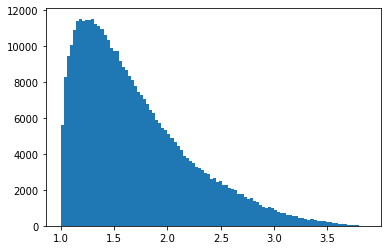

TFile: name=/home/sebouh/di-hadron/simul/D/6.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/1.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/4.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/9.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/5.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/8.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/2.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/3.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/D/7.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/C/6.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/C/1.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/C/4.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/C/9.root, title=, option=READ
TFile: name=/home/sebouh/di-hadron/simul/C/5.root, title=, option=READ
TFile:

Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN
Error in <TROOT::TVector2::Phi_mpi_pi>: function called with NaN


In [5]:
for a in 'D C Fe Pb'.split():
    dfs_mc={}
    path = f'/home/sebouh/di-hadron/simul/{a}/'
    #path = '/home/seba/di-hadron/simul/'
    Files = listdir(path) 
    df_mc[a],df_mc[f'{a}_mix'], df_mc[f'{a}_trigger'] = [None,None,None]
    count =0
    for name in Files:
        print('done with: ', count, ' files')
        count=count+1
        if( '.root' not in name): continue

        filename = path+name
        print(filename)
        pairs, pairs_mix, trigger = getDataframes(filename,tree_name='ntuple_sim',Target=1,
                                                  isMC=True,keepH2FailRecon=True, keepH1FailRecon=False, 
                                                  keepEFailRecon=False, 
                                                  maxevents=1e8, makeTriggerTuple=False)
        df_mc[f'{a}'] = pd.concat([ df_mc[f'{a}'], pairs])
        df_mc[f'{a}_mix'] = pd.concat([ df_mc[f'{a}_mix'], pairs_mix])
        df_mc[f'{a}_trigger'] = pd.concat([ df_mc[f'{a}_trigger'], trigger])

        #plt.hist(pairs.h1_pid)
        
        print('Entries in the dataframe so far are ', df_mc[a].shape[0])
        print('Entries in the MIXED dataframe so far are ', df_mc[f'{a}_mix'].shape[0])
        print('Entries in the trigger dataframe so far are ', df_mc[f'{a}_trigger'].shape[0])
    
        import pickle
        with open(f"MC_pion_proton_pairs_{a}.pkl", "wb") as f:
            pickle.dump({a:df_mc[a] for a in f"{a} {a}_trigger {a}_mix".split()}, f, pickle.HIGHEST_PROTOCOL)
        del pairs, pairs_mix, trigger
plt.hist(df_mc['D'].Q2, bins=100)
plt.show()

In [7]:
!ls -lth MC_pion_proton_pairs_*.pkl

-rw-rw-r-- 1 sebouh sebouh 133M Jan 24 23:52 MC_pion_proton_pairs_Pb.pkl
-rw-rw-r-- 1 sebouh sebouh 249M Jan 24 23:35 MC_pion_proton_pairs_Fe.pkl
-rw-rw-r-- 1 sebouh sebouh 579M Jan 24 23:04 MC_pion_proton_pairs_C.pkl
-rw-rw-r-- 1 sebouh sebouh 600M Jan 24 21:53 MC_pion_proton_pairs_D.pkl


In [17]:
#root_pandas.to_root_multi('MC_Pairs_%s_no_h2_kin_cuts.root'%a, df_mc)
root_pandas.to_root(df_mc[a],'MC_Pairs_%s_no_h2_kin_cuts.root'%a, a)

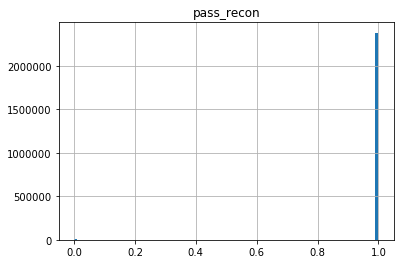

In [6]:
df_mc['D'].hist("pass_recon",bins=100)
plt.show()

In [16]:
help(root_pandas)

Help on module root_pandas:

NAME
    root_pandas

FUNCTIONS
    read_root(filename, treename=None, N=None)
    
    to_root(df, filename, treename)
        #create single-tree root file
    
    to_root_multi(filename, d)
        #create root file with multiple trees:
        # d is a map of tree name to data frames {"tree1":df1, "tree2":df2 ... etc}

FILE
    /home/sebouh/di-hadron/root_pandas.py




# Saving the MC file

In [ ]:
for target in ['Pb']:
    to_root(df_mc['%s'%target],'MC_Pairs_%s.root'%target, key='%s'%target)
    to_root(df_mc['%s_mix'%target],'MC_Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df_mc['%s_trigger'%target],'MC_Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')

In [ ]:
for kk in range(5):
    print('inside the loop',kk)
print('outside the loop',kk)    

In [ ]:
    for ievt  in range(mytree.GetEntries()):
        mytree.GetEntry(ievt)   
        particles = []  ## this is how you define a list in python, this is created for each event
        for i in range(len(mytree.pid)):
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i], mytree.Nphe[i], mytree.deltaZ[i], mytree.FidCheckCutPiPlus[i])     
            particles.append(i_part)
            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
                #tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #for j in range(len(mytree.pid)): 
                #    if i==j: continue
                #    tupla['dphi'].append(dphi)
                #print(ievt,i,j)
                for mixparticle in ParticlesFromPrevious:
                    print('inside mixparticle loop')
                    #print(i,mixparticle, ParticlesFromPrevious)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)

                    mixparticle.redefine(virtual_photon) #recalculates variables in this' event photon frame (not in the previous one)
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    return df, df_mix, df_trigger        
        
        
        